# KMeans Clutering Model 

* We will select the features optimal for a clusterization model
* We will not include demographic data, as we want to segregate based on behavior 

In [9]:
import joblib
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score


In [2]:
# Load the master data
X_master = pd.read_csv('../data/processed/master_features.csv')
tracking = pd.read_csv('../data/processed/tracking_labels.csv')

# Keep loyalty numbers and churn for analysis later
loyalty_numbers = tracking['Loyalty Number'].copy()
churn_labels = tracking['Churn'].copy()

# Focus on behavioral and value-based features
kmeans_features = [
    'Salary', 'CLV',
    'Total Flights', 'Distance',
    'Points Accumulated', 'Points Redeemed', 'Dollar Cost Points Redeemed',
    'Points Most Recent', 'Avg Monthly Points', 'Activity Volatility',
    'Overall Trend',
    'Customer Age (Years)'
]

# Select features
X_cluster = X_master[kmeans_features].copy()

print(f"\nClustering data shape: {X_cluster.shape}")


Clustering data shape: (15176, 12)


* We need to scale features for the clustering algorithm

In [3]:
# Scale features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Convert back to DataFrame for easier handling
X_cluster_scaled_df = pd.DataFrame(
    X_cluster_scaled,
    columns=kmeans_features,
    index=X_cluster.index
)

print(" Features scaled (mean=0, std=1)")
print(f"\nScaled data shape: {X_cluster_scaled_df.shape}")


 Features scaled (mean=0, std=1)

Scaled data shape: (15176, 12)


###  Testing different number of clusters
* We will choose the optimal number of clusters based on inertia, silhouette, and davies bouldin scores # Scale features



Testing different cluster counts...


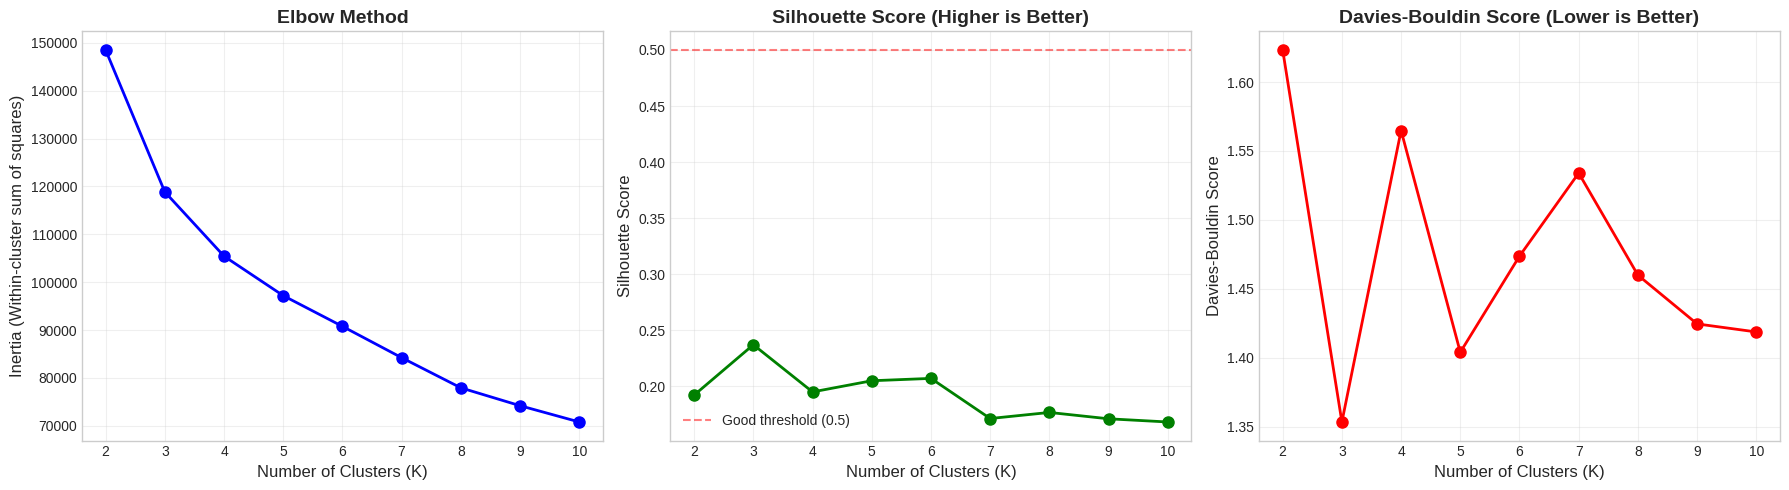

In [4]:

# Test different numbers of clusters
k_range = range(2, 11)  # Test 2 to 10 clusters
inertias = []
silhouette_scores = []
davies_bouldin_scores = []

print("\nTesting different cluster counts...")

for k in k_range:
    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)

    # Calculate metrics
    inertia = kmeans.inertia_
    silhouette = silhouette_score(X_cluster_scaled, kmeans.labels_)
    db_score = davies_bouldin_score(X_cluster_scaled, kmeans.labels_)

    inertias.append(inertia)
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(db_score)

# Visualize the metrics
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Elbow curve (Inertia)
axes[0].plot(k_range, inertias, 'b-o', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].set_xticks(k_range)

# Silhouette score (higher is better)
axes[1].plot(k_range, silhouette_scores, 'g-o', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].set_xticks(k_range)
axes[1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Good threshold (0.5)')
axes[1].legend()

# Davies-Bouldin score (lower is better)
axes[2].plot(k_range, davies_bouldin_scores, 'r-o', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[2].set_ylabel('Davies-Bouldin Score', fontsize=12)
axes[2].set_title('Davies-Bouldin Score (Lower is Better)', fontsize=14, fontweight='bold')
axes[2].grid(alpha=0.3)
axes[2].set_xticks(k_range)

plt.tight_layout()
plt.show()

optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]



* Based on the metrics, we will use k = 3 

#### Training Clustering Model 

In [5]:
optimal_k = 3 

# Train final model
kmeans_final = KMeans(
    n_clusters=optimal_k,
    random_state=42,
    n_init=10,
    max_iter=300
)

print("\nTraining K-Means model...")
cluster_labels = kmeans_final.fit_predict(X_cluster_scaled)

print("Model trained successfully")
print(f"   Clusters: {optimal_k}")
print(f"   Iterations: {kmeans_final.n_iter_}")
print(f"   Inertia: {kmeans_final.inertia_:.0f}")

# Add cluster labels to original data
X_cluster['Cluster'] = cluster_labels
X_master['Cluster'] = cluster_labels

# Cluster distribution
print("\n=== CLUSTER DISTRIBUTION ===")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print(cluster_counts)
print("\nCluster sizes:")
for cluster_id, count in cluster_counts.items():
    print(f"  Cluster {cluster_id}: {count:,} customers ({count/len(cluster_labels)*100:.1f}%)")


Training K-Means model...


Model trained successfully
   Clusters: 3
   Iterations: 12
   Inertia: 118867

=== CLUSTER DISTRIBUTION ===
0     647
1    9941
2    4588
Name: count, dtype: int64

Cluster sizes:
  Cluster 0: 647 customers (4.3%)
  Cluster 1: 9,941 customers (65.5%)
  Cluster 2: 4,588 customers (30.2%)


#### Evalutating Characteristics of Clusters

In [6]:
# Calculate cluster centers (in original scale)
cluster_centers_scaled = kmeans_final.cluster_centers_
cluster_centers_original = scaler.inverse_transform(cluster_centers_scaled)

cluster_profiles = pd.DataFrame(
    cluster_centers_original,
    columns=kmeans_features
)

# Add cluster size
cluster_profiles['Cluster Size'] = cluster_counts.values
cluster_profiles['Cluster'] = range(optimal_k)

# Add churn rate per cluster
cluster_churn_rate = []
for i in range(optimal_k):
    cluster_mask = cluster_labels == i
    churn_rate = churn_labels[cluster_mask].mean()
    cluster_churn_rate.append(churn_rate)

cluster_profiles['Churn Rate'] = cluster_churn_rate

# Detailed view for each cluster

for cluster_id in range(optimal_k):
    print(f"\n--- CLUSTER {cluster_id} ---")
    cluster_mask = cluster_labels == cluster_id
    cluster_data = X_cluster[cluster_mask]

    print(f"Size: {cluster_mask.sum():,} customers ({cluster_mask.sum()/len(cluster_labels)*100:.1f}%)")
    print(f"Churn Rate: {cluster_churn_rate[cluster_id]:.2%}")

    print("\nKey Characteristics:")
    print(f"  Avg Salary: ${cluster_data['Salary'].mean():,.0f}")
    print(f"  Avg CLV: ${cluster_data['CLV'].mean():,.0f}")
    print(f"  Avg Total Flights: {cluster_data['Total Flights'].mean():.1f}")
    print(f"  Avg Distance: {cluster_data['Distance'].mean():,.0f} km")
    print(f"  Avg Points Accumulated: {cluster_data['Points Accumulated'].mean():,.0f}")
    print(f"  Avg Customer Age: {cluster_data['Customer Age (Years)'].mean():.1f} years")


--- CLUSTER 0 ---
Size: 647 customers (4.3%)
Churn Rate: 8.81%

Key Characteristics:
  Avg Salary: $72,162
  Avg CLV: $8,193
  Avg Total Flights: 53.9
  Avg Distance: 82,471 km
  Avg Points Accumulated: 123,207
  Avg Customer Age: 0.0 years

--- CLUSTER 1 ---
Size: 9,941 customers (65.5%)
Churn Rate: 6.60%

Key Characteristics:
  Avg Salary: $78,407
  Avg CLV: $7,978
  Avg Total Flights: 39.7
  Avg Distance: 59,700 km
  Avg Points Accumulated: 60,258
  Avg Customer Age: 3.5 years

--- CLUSTER 2 ---
Size: 4,588 customers (30.2%)
Churn Rate: 24.37%

Key Characteristics:
  Avg Salary: $77,422
  Avg CLV: $7,855
  Avg Total Flights: 17.4
  Avg Distance: 25,288 km
  Avg Points Accumulated: 25,677
  Avg Customer Age: 1.3 years


* Clusters have well defined, significant differences 
* This means clusters are well defined

#### Visualization of Clusters

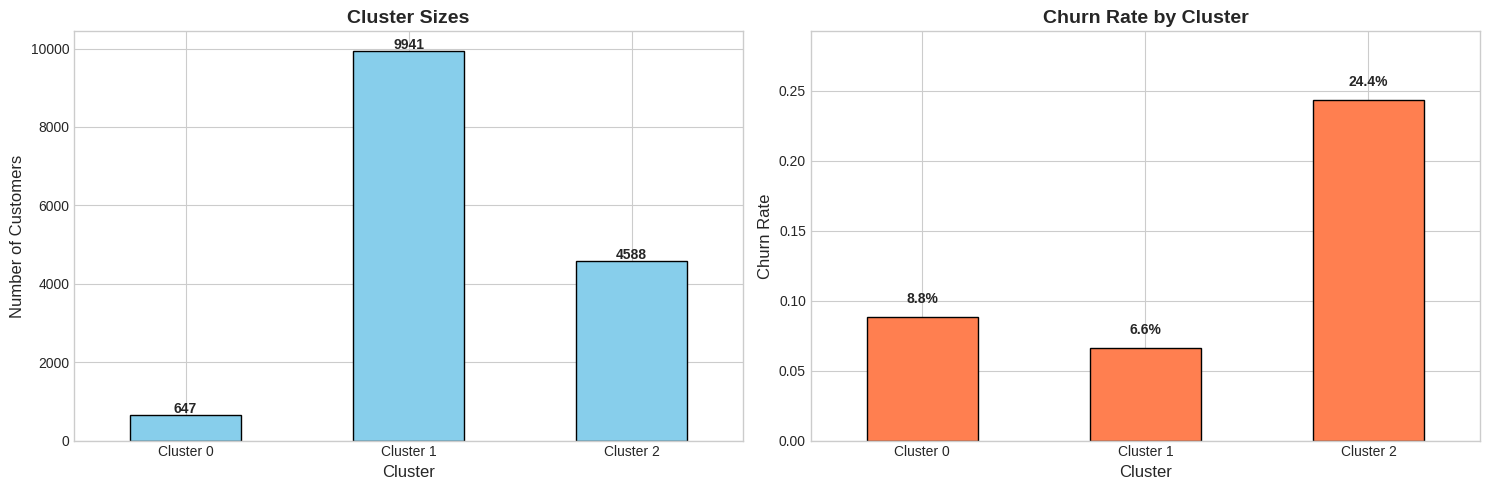


 PCA projection...


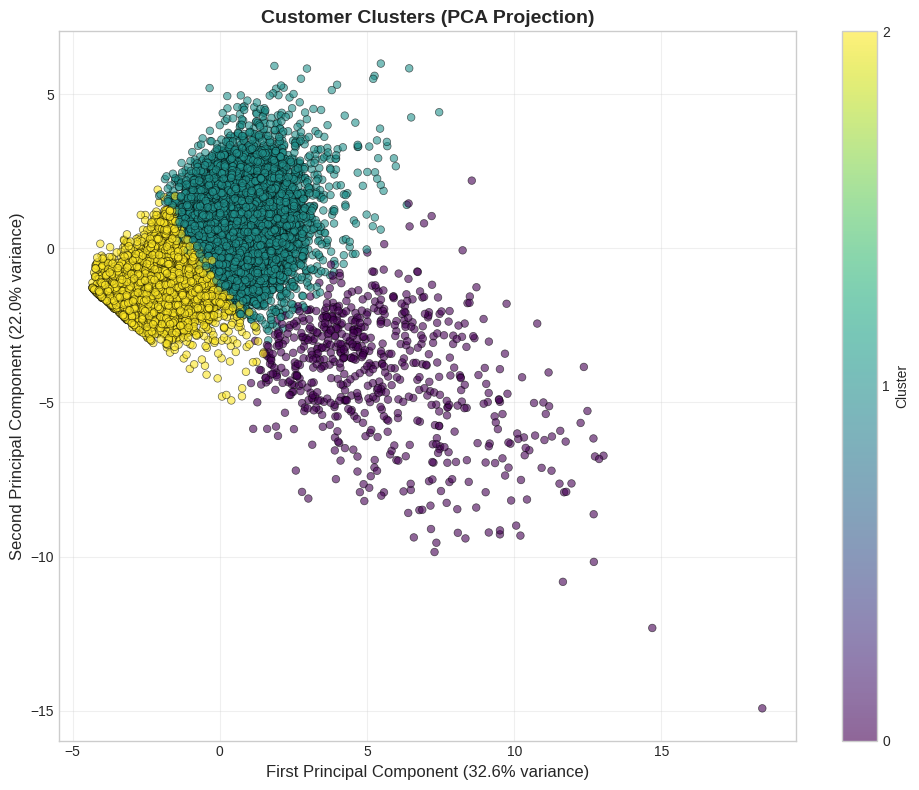


 Key metrics comparison...


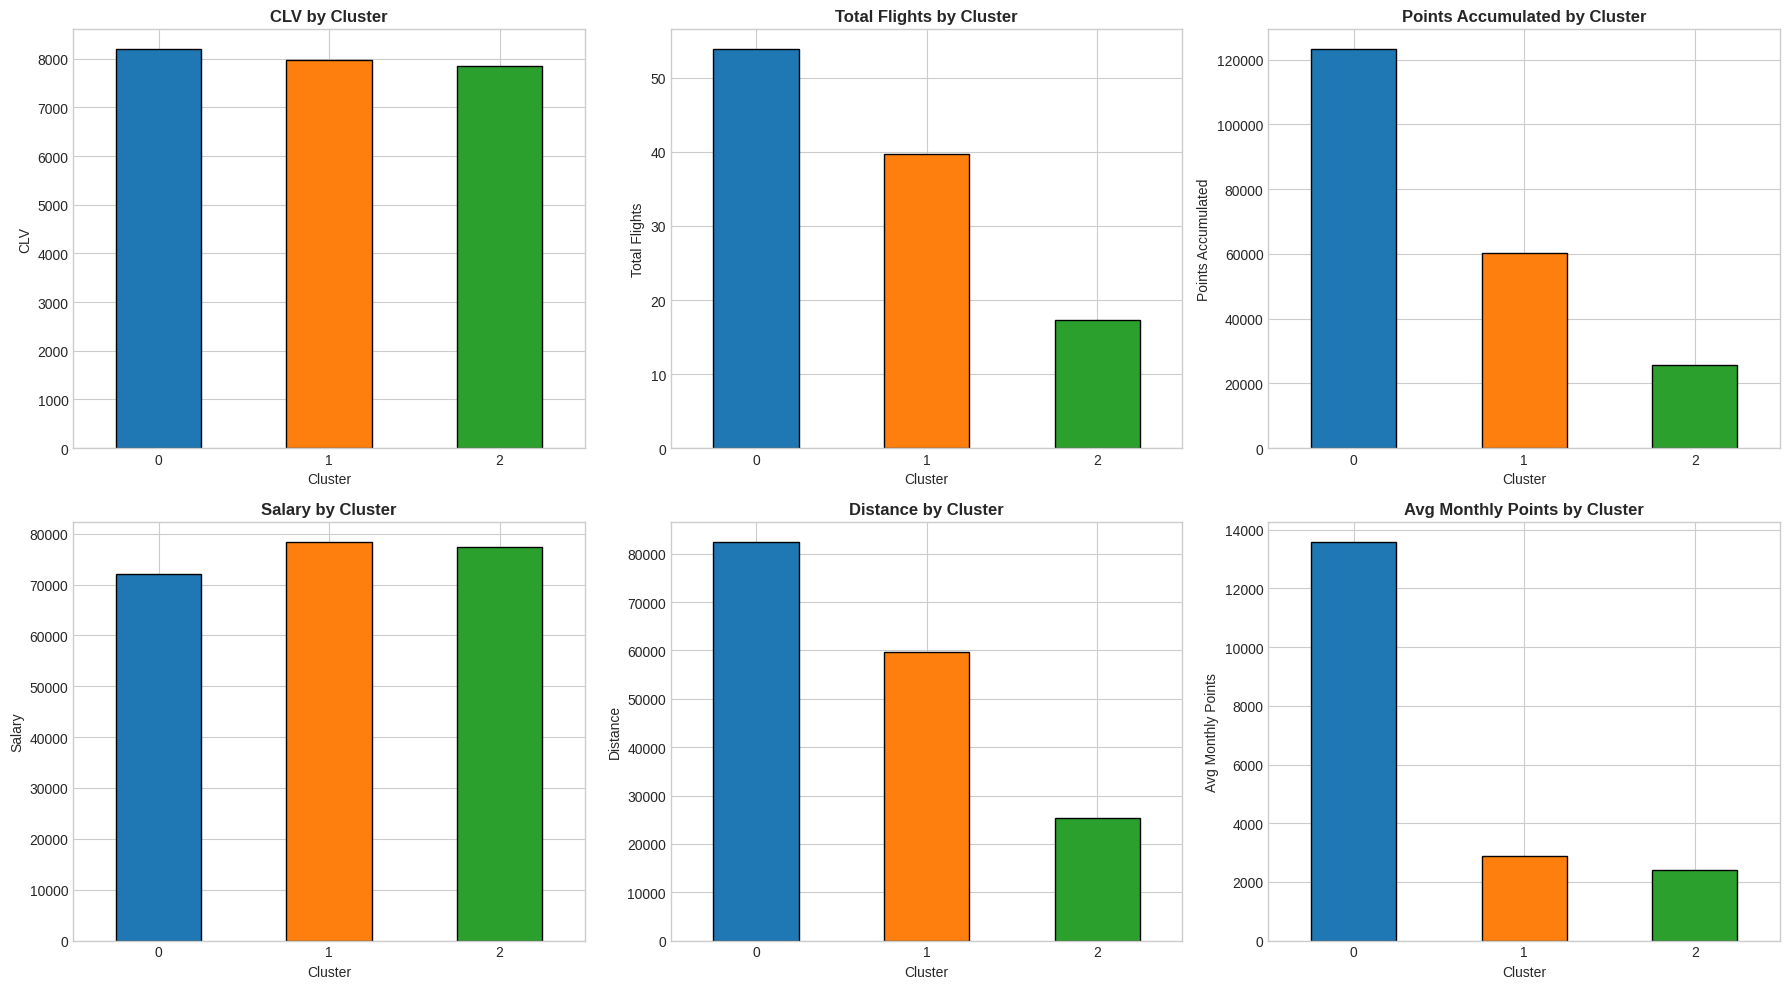

In [7]:
from sklearn.decomposition import PCA

# Cluster size and churn rate
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Cluster sizes
cluster_counts.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Number of Customers', fontsize=12)
axes[0].set_title('Cluster Sizes', fontsize=14, fontweight='bold')
axes[0].set_xticklabels([f'Cluster {i}' for i in range(optimal_k)], rotation=0)

# Add count labels on bars
for i, v in enumerate(cluster_counts):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Churn rate by cluster
churn_rates = pd.Series(cluster_churn_rate, index=range(optimal_k))
churn_rates.plot(kind='bar', ax=axes[1], color='coral', edgecolor='black')
axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('Churn Rate', fontsize=12)
axes[1].set_title('Churn Rate by Cluster', fontsize=14, fontweight='bold')
axes[1].set_xticklabels([f'Cluster {i}' for i in range(optimal_k)], rotation=0)
axes[1].set_ylim(0, max(cluster_churn_rate) * 1.2)

# Add percentage labels
for i, v in enumerate(cluster_churn_rate):
    axes[1].text(i, v + 0.01, f'{v:.1%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# PCA visualization (2D)
print("\n PCA projection...")

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cluster_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                     c=cluster_labels, cmap='viridis',
                     alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Cluster', ticks=range(optimal_k))
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title('Customer Clusters (PCA Projection)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Key metrics by cluster
print("\n Key metrics comparison...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metrics = ['CLV', 'Total Flights', 'Points Accumulated', 'Salary', 'Distance', 'Avg Monthly Points']
colors = ['tab:blue', 'tab:orange', 'tab:green']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    cluster_profiles.plot(x='Cluster', y=metric, kind='bar', ax=ax,
                         color=colors, edgecolor='black', legend=False)
    ax.set_xlabel('Cluster', fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.set_title(f'{metric} by Cluster', fontsize=12, fontweight='bold')
    ax.set_xticklabels([f'{i}' for i in range(optimal_k)], rotation=0)

plt.tight_layout()
plt.show()


In [11]:
joblib.dump(kmeans_final, '../models/clustering_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')


['../models/scaler.pkl']